# D. Distributed GP with TurboGP

TurboGP provides methods that allow to deploy a GP in a distributed fashion/environment. These methods are based on the multi-population (also known as _island_) models thoroughly studied and documented in GP literature[1]. The way they work is that independent GP processes are launched, each one containing its own population isolated from the rest (hence the _island_ concept), but exchanging individuals every certain number of generations. 

This apprach can be used on a single machine with multiple CPU cores -as will be shown in this notebook-, but could also, under certain circumstances, be deployed in fully distributed enviroments, i.e. clusters and even networked machines (LANs, VPNs, clouds, etc.)

The advantage of these models is not only that they take better advantage of machines with multiple CPU (because, unlike the standard parallel individual evaluation approach, island models do parallelize -partially or entirely- genetic operations), but also that the segmented population approach provides a mechanism that encourages greater individual diversity in the overall multi-population GP, which can help to tackle harder learning problems [1].

The difficulty on deploying these methods, under a Python implementation, is that Python does not make it easy to launch truly parallel processes, therefore this approach formally requires to configure and launch each _island_ manually. TurboGP library provides methods to handle the rest of the distributed algorithm (``import`` and ``export`` operations).

Nevertheless, TurboGP does provide a function that tries to serve as much as possible as a drop-in replacement for the standard _sci-kit learn alike_ interface shown in previous notebooks. The purpose of such function is to easly deploy distributed GPs on single machines with multiple CPUs (in order to deploy these models in truly distributed environments, a manual effort is still required).

This notebook shows how to use such function, while briefly describing what is happening behind the scenes.


1. Tomassini, M. (2006). Spatially structured evolutionary algorithms: Artificial evolution in space and time. Springer Science & Business Media.

---

As an example, we will take the image denoising example of notebook B, and deploy it on an islands model. We will try to keep the changes as minimal as possible, in order to demostrate the drop-in replacement ability of TurboGP provided class ``GeneticProgramD``.

Import necessary libraries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle                 # To load the dataset we will be using

from genetic_program import GeneticProgramD

from NonConvolutionalFilter import *                    # This is the GP individual we will use.
from GPUtils import binary_tournament

Load training dataset:

In [2]:
# Load file
f = np.load('bsds50-21x21-mini.npz', allow_pickle=True)

# dataset can be downloaded from: https://www.dropbox.com/s/5pcmbw9dspbfdt0/bsds50-21x21-mini.npz?dl=0 

# Load images only
x_training = f['x_train_50']
y_training = f['y_residual_50']

x_train = x_training[0:12000]
y_train = y_training[0:12000]

batchesX = x_train.reshape(40, 300, 21, 21)
batchesY = y_train.reshape(40, 300, 21, 21)

Separate some data for testing:

In [3]:
# Testing set

x_test = x_training[12000:14000]
y_test = y_training[12000:14000]

Define GP run parameters:

In [4]:
lowlevel = ['ADD', 'SUB', 'MUL', 'DIV', 'RELU', 'MAX', 'MEAN', 'MIN', 'X2', 'SIN', 'COS', 'SQRT'] # Primitives
GeneticProgramD.set_primitives(lowlevel=lowlevel)

#gp_individual_class = NonConvFilter            # Type of individual to evolve
ind_params = {'lateral_window_size':21, 'complexity':9} 

oper = [NonConvFilter.mutation,                 # Genetic operations to use.
        NonConvFilter.protected_crossover]      # notice how they are defined by the type of individual we will evolve

oper_prob = [.5, .5]                            # Probabity of each GP operation (in the same order as declared above)
oper_arity = [1, 2]                             # How many parents required by each operation.

Initialize predictor requesting a regressor as GP individual to evolve:

In [5]:
GP = GeneticProgramD(individual_class=NonConvFilter , 
                    ind_params=ind_params, 
                    operations=oper, 
                    operations_prob=oper_prob, 
                    operations_arity=oper_arity, 
                    pop_size=500, 
                    epochs=3,
                    pop_dynamics="Steady_State", 
                    online=True, 
                    minimization=True,
                    sel_mechanism=binary_tournament,
                    n_jobs=5,
                    no_populations=4, 
                    every_gen=10, 
                    top_percent=.1, 
                    topology='dynamic_random')

Notice how there are some extra parameters involved: 
- ``no_populations``, number of populations, or islands;
- ``every_gen``, each many generations populations will export and import individuals to/from other islands;
- ``top_percent``, percentage of elite individual to be imported/exported
- ``topology``, policy for individuals' exchange among populations (e.g. ring, random, dynamic random, etc.)

Notice also how, even though we requested 4 population, i.e. independent GP process, to be launched, the ``n_jobs`` parameter is still used, and it means how many CPU cores/threads will be assigned to each GP process (i.e., island). 
This notebook was run on a 10-Core/20-thread Intel Xeon CPU, and here we configure the distributed GP to make full use of the computational resources available (4 populations $\times$ 5 CPU each $=$ 20 threads).

Train/Evolve it!

In [6]:
gp_img_den = GP.fit(batchesX, batchesY)

Population 2 finished
Population 3 finished
Population 1 finished
Population 0 finished


TurboGP ``GeneticProgramD`` will package the GP parameters specified in a set of JSON files, one file per island. The dataset will also be packaged in a pickled file, and then it will launch TurboGP from the OS command line (as seen in the previous notebook) as many times as populations were requested.

The advantage of this approach is that we can achieve a true parallelism, even though TurboGP is implemented in Python. The disadvantage is that there is no simple way to monitor from this very notebook or python shell, the individual progress on any of the GP processes launched. 

In future versions of TurboGP we plan to code some workaround for this issue.

Test it against OOB data:

In [7]:
GP.natural_score(x_test, y_test)

0.00625008

Distributed Evolutionary models can sometimes improve efficacy (achieve better solutions, given the same computational resources), help in stabilizing GP performance across runs (decrease variance in results, which is even more important than higher efficiency), both, or none; all depends on the particular problem being tackled. For a formal study on these types of evolutionary models, please refer to [1].

In this case we can notice we achieve a considerably better solution than with the regular, single-population, panmictic model.

``GeneticProgramD`` automatically retrieves the best performing individual, by picking the best individual among the top performing individuals of each population. 

We can plot the model found:

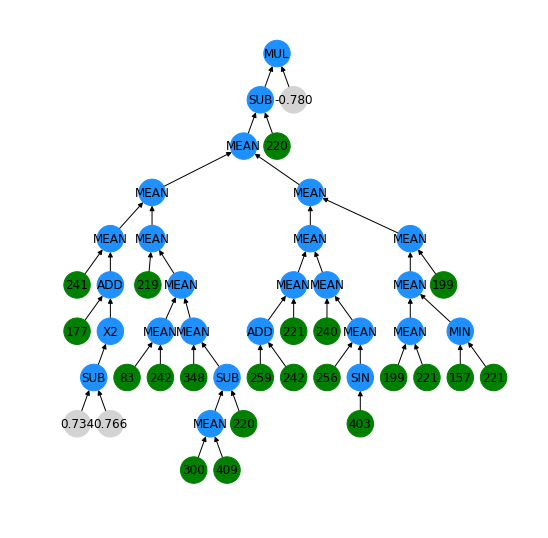

In [8]:
from GPUtils import get_graph
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(gp_img_den.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

We can also perform some predictions with it, to visually verify if it truly performs better than the single-pop model:

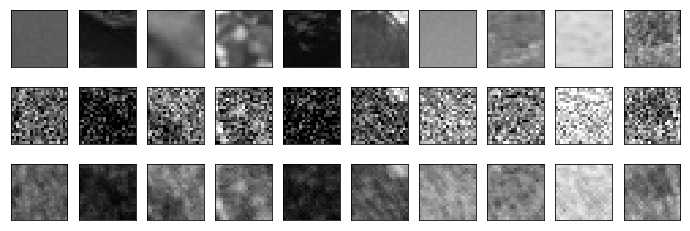

In [9]:
from matplotlib.colors import Normalize 

noise_mask = GP.predict(x_training[0:10])
reconstruction = x_training[0:10] - noise_mask

y_label = f['y_train']


norm = Normalize(vmin=0, vmax=1, clip=True)

n = 10  # how many digits we will display
plt.figure(figsize=(12, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_label[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_training[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(reconstruction[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---

``GeneticProgramD`` supports Low Level primitives, as well as _mezzanine_ ones along _trimmers_, as shown below.
It does not, however, supports high level primitives, yet.

In [10]:
batchesX = x_train.reshape(60, 200, 21, 21)
batchesY = y_train.reshape(60, 200, 21, 21)

In [11]:
from NonConvolutionalMezzanineFilter import *           # This is the GP individual we will use.

mezzanine = ['mMEAN', 'mSTD', 'mMAX', 'mMIN', 'mMED']
trimmers = ['TFull', 'TNorW', 'TNorE', 'TSouW', 'TSouE', 'TCenter3', 'TCenter5', 'TOuterR']
GeneticProgramD.set_primitives(lowlevel=lowlevel, mezzanine=mezzanine, trimmers=trimmers)

#gp_individual_class = NonConvFilter            # Type of individual to evolve
ind_params = {'lateral_window_size':21, 'complexity':9, 'high_depth_allocation':.5} 

oper = [NonConvFilter.mutation,                 # Genetic operations to use.
        NonConvFilter.protected_crossover]      # notice how they are defined by the type of individual we will evolve

In [12]:
GP = GeneticProgramD(individual_class=NonConvFilter , 
                    ind_params=ind_params, 
                    operations=oper, 
                    operations_prob=oper_prob, 
                    operations_arity=oper_arity, 
                    pop_size=500, 
                    epochs=1,
                    pop_dynamics="Steady_State", 
                    online=True, 
                    minimization=True,
                    sel_mechanism=binary_tournament,
                    n_jobs=5,
                    no_populations=4, 
                    every_gen=10, 
                    top_percent=.1, 
                    topology='dynamic_random')

Trainig it / Evolve it

In [13]:
GP.fit(batchesX, batchesY)

Population 2 finished
Population 0 finished
Population 3 finished
Population 1 finished


In [15]:
GP.natural_score(x_test, y_test)

0.0056958366

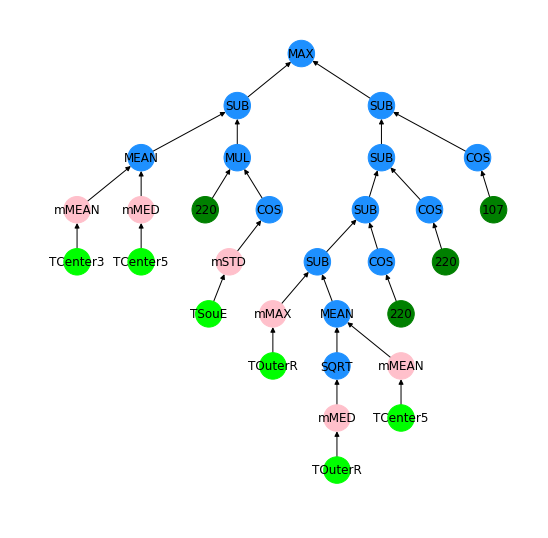

In [18]:
plt.figure(figsize=(7,7))
graph, labels, color_map = get_graph(GP.model_.tree)
nx.draw(graph, pos=nx.nx_agraph.graphviz_layout(graph.reverse(), prog="dot"), with_labels=True, labels=labels, node_size=700, node_color=color_map)

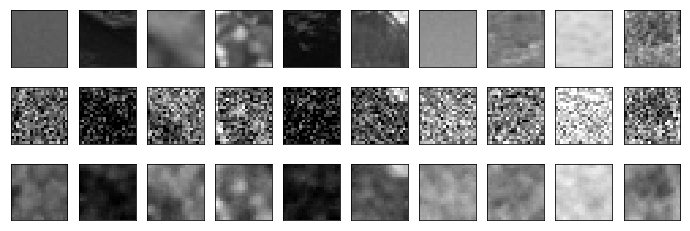

In [21]:
from matplotlib.colors import Normalize 

noise_mask = GP.predict(x_training[0:10])
reconstruction = x_training[0:10] - noise_mask

y_label = f['y_train']


norm = Normalize(vmin=0, vmax=1, clip=True)

n = 10  # how many digits we will display
plt.figure(figsize=(12, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(y_label[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_training[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n*2)
    plt.imshow(reconstruction[i], norm=norm)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()